/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Number of files processed: 20000
Number of images arrays loaded: 20000
Number of substructure values arrays loaded: 20000
Epoch 1/50


2024-01-08 15:36:15.558320: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


400/400 [==============================] - 32s 64ms/step - loss: 0.9072 - mean_squared_error: 0.9072 - val_loss: 0.0362 - val_mean_squared_error: 0.0362
Epoch 2/50
400/400 [==============================] - 24s 60ms/step - loss: 0.0532 - mean_squared_error: 0.0532 - val_loss: 0.6528 - val_mean_squared_error: 0.6528
Epoch 3/50
400/400 [==============================] - 24s 60ms/step - loss: 0.0045 - mean_squared_error: 0.0045 - val_loss: 0.4742 - val_mean_squared_error: 0.4742
Epoch 4/50
400/400 [==============================] - 24s 60ms/step - loss: 7.3171e-04 - mean_squared_error: 7.3171e-04 - val_loss: 0.1519 - val_mean_squared_error: 0.1519
Epoch 5/50
400/400 [==============================] - 24s 60ms/step - loss: 3.5000e-04 - mean_squared_error: 3.5000e-04 - val_loss: 0.1255 - val_mean_squared_error: 0.1255
Epoch 6/50
400/400 [==============================] - 24s 60ms/step - loss: 3.2001e-04 - mean_squared_error: 3.2001e-04 - val_loss: 0.0657 - val_mean_squared_error: 0.0657
Epo

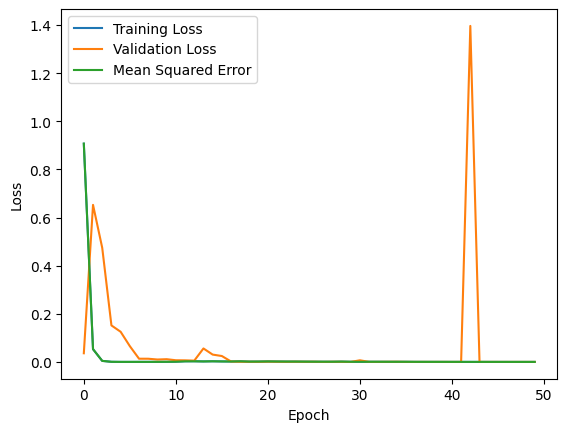

In [1]:
import os
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
import matplotlib.pyplot as plt

# Specify the directory path
directory_path = '/kaggle/input/again-zip-lens/lens_data_alt-open/lens_data'

# Get a list of all .npy files in the directory
npy_files = [file for file in os.listdir(directory_path) if file.endswith('.npy')]

# Initialize lists to store data from all files
all_images = []
all_substructure_values = []

# Loop through each .npy file
for npy_file in npy_files:
    # Load data from the current file
    file_path = os.path.join(directory_path, npy_file)
    data = np.load(file_path, allow_pickle=True)
    
    # Assuming images are at index 0 and substructure values at index 1
    images = data[0]
    substructure_values = data[1]
    
    # Check if images and substructure values are non-empty before appending
    if images.size > 0 and substructure_values.size > 0:
        all_images.append(images)
        all_substructure_values.append(substructure_values)

# Check if at least one set of data is non-empty
if all_images and all_substructure_values:
    # Debug prints
    print("Number of files processed:", len(npy_files))
    print("Number of images arrays loaded:", len(all_images))
    print("Number of substructure values arrays loaded:", len(all_substructure_values))
    
    # Concatenate the lists to create arrays
    all_images = np.stack(all_images, axis=0)
    all_substructure_values = np.vstack(all_substructure_values)

    # Reshape the images to be compatible with Conv2D layers
    height, width = all_images.shape[1], all_images.shape[2]
    channels = 1  # Assuming grayscale images, change to 3 for RGB
    all_images = all_images.reshape(-1, height, width, channels)

    # Split the data into train and test sets
    test_size = 0.2  # You can adjust the test size as needed
    train_images, test_images, train_substructure_values, test_substructure_values = train_test_split(
        all_images, all_substructure_values, test_size=test_size, random_state=42
    )

    # Build regression model
    model = Sequential()
    model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(height, width, channels)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(256, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.3))

    model.add(Conv2D(512, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.3))

    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='linear'))  # Linear activation for regression

    # Compile the model with MSE as the metric
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error'])


    # Add the callback to the model
    hist=model.fit(train_images, train_substructure_values, epochs=50, validation_split=0.2)
    # Evaluate the model on the test set
    test_loss, test_mse = model.evaluate(test_images, test_substructure_values)
        
    # Plot the loss vs mean squared error graph
    plt.plot(hist.history['loss'], label='Training Loss')
    plt.plot(hist.history['val_loss'], label='Validation Loss')
    plt.plot(hist.history['mean_squared_error'], label='Mean Squared Error')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()